In [1]:
import opdata
import numpy as np
import cv2 as cv
import sys
import dataProc
sys.path.append('./preprocess/')
sys.path.append('./analy/')
import preprocess.visualize as visualize
import preprocess.ecg as Ecg
import preprocess.pseudoEcg as pseudoEcg
import analysis
import matplotlib.pyplot as plt
import resUnet3d
import analy.activation as activation

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Optical mapping

In [2]:
import importlib
importlib.reload(opdata)

<module 'opdata' from '/notebooks/nb/ecg2mem/opdata.py'>

In [3]:
path = '/mnt/Jalife/ExperimentData/20190717-1/op/C001H001S0006/'
op = opdata.OpVmem(path, (256, 256), (0, 0, 256, 256), end=2000)

In [4]:
! mkdir /mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190717-1-6

mkdir: cannot create directory '/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190717-1-6': File exists


In [ ]:
raw_vmem_video = visualize.makeMovie(op.vmem, 'plasma', 30)
raw_vmem_video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190717-1-6/1_raw.mp4')

In [5]:
op.spatialFilter(3)
# op.temporalFilter(5)
op.highPassFilter(2, 3)

In [ ]:
filtered_vmem_video = visualize.makeMovie(op.vmem, 'plasma', 30)
filtered_vmem_video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190717-1-6/1_filtered.mp4')

In [ ]:
pxnormed_vmem = dataProc.channelNormalize(op.vmem)
video = visualize.makeMovie(pxnormed_vmem, 'plasma', 30)
video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190717-1-6/1_pxnormed.mp4')

# Vmem

In [ ]:
path = '/mnt/Jalife/ExperimentData/20190717-1/op/C001H001S0002/'
op = opdata.OpVmem(path, (256, 256), (0, 0, 256, 256), end=2000)

## activation timeとVmemの比較

In [ ]:
plt.figure(figsize=(15,90))
fig_actv = visualize.plot(ecg_actv)

for  k in range(0,25):
    plt.subplot(50, 1, 2*k+1)
    plt.plot(ecg_actv[:, k])
    plt.vlines(vmem_actv.activation_time[k],0,1,color='r')
    plt.title('%d-ECG' % (k+1))

    plt.subplot(50, 1, 2*k+2)
    plt.plot(op.vmem[250+16: 250+16+1440, int(elec_256[k,0]), int(elec_256[k,1]), 0])
    plt.title('%d-Vmem' % (k+1))
    

# ECG

In [6]:
importlib.reload(Ecg)

<module 'preprocess.ecg' from '/notebooks/nb/ecg2mem/preprocess/ecg.py'>

## raw

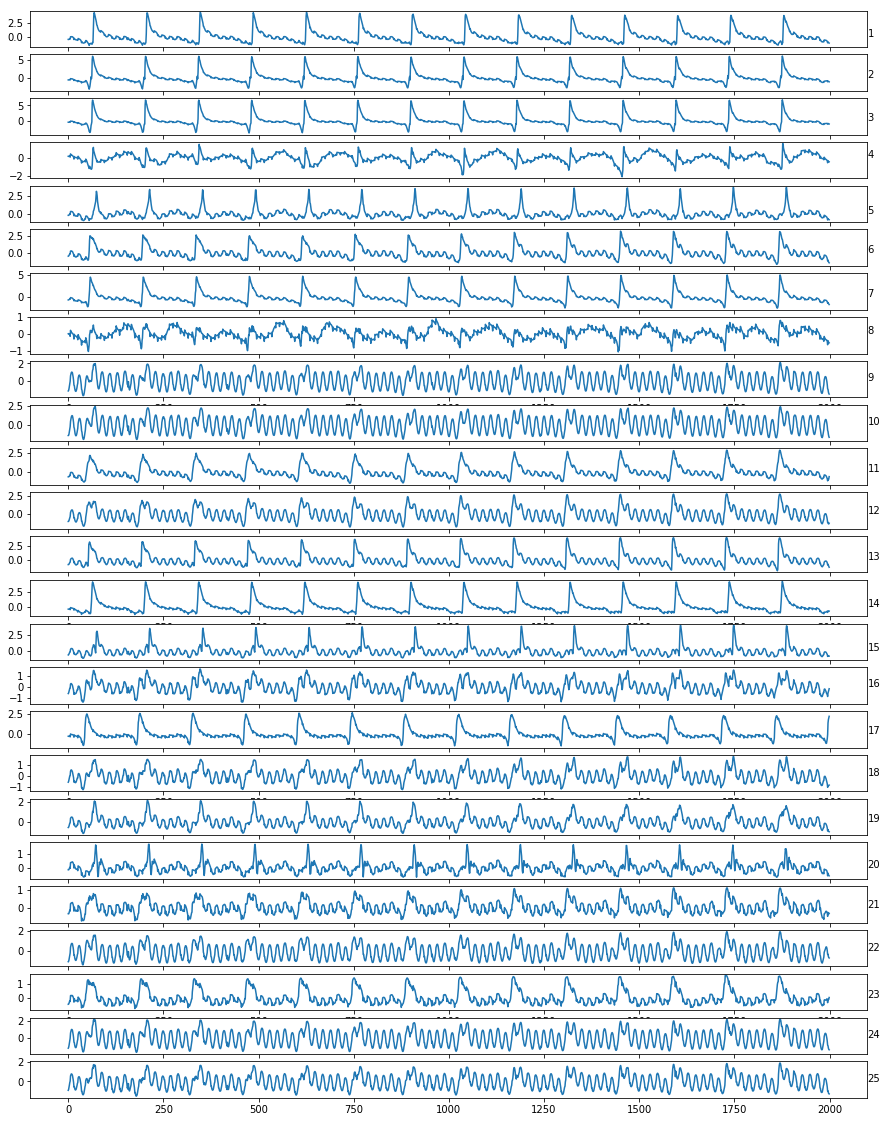

In [7]:
ecg_raw = Ecg.load('/mnt/Jalife/ExperimentData/20190717-1/ecg/C001H001S0006/20190717181544697.csv', 0, 2000,1,26)
fig_ecg_raw = visualize.plot(ecg_raw)
fig_ecg_raw

## filter

In [8]:
ecg = Ecg.filterEcg(ecg_raw, 1000, 150, 3, 2, 3, (50, 100), (3, 3))

In [ ]:
#1~21横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k])

In [ ]:
#2~22 横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+1])

In [ ]:
#3~23 横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+2])

In [ ]:
#4~24 横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+3])

In [ ]:
#5~25横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+4])

In [ ]:
#1~5 縦比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,k])

In [ ]:
#6~10 縦比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,k+5])

In [ ]:
#11~15 縦比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,k+10])

In [ ]:
#16~20 縦比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,k+15])

In [ ]:
#21~25 縦比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,k+20])

In [ ]:
fig_ecg = visualize.plot(ecg)
fig_ecg

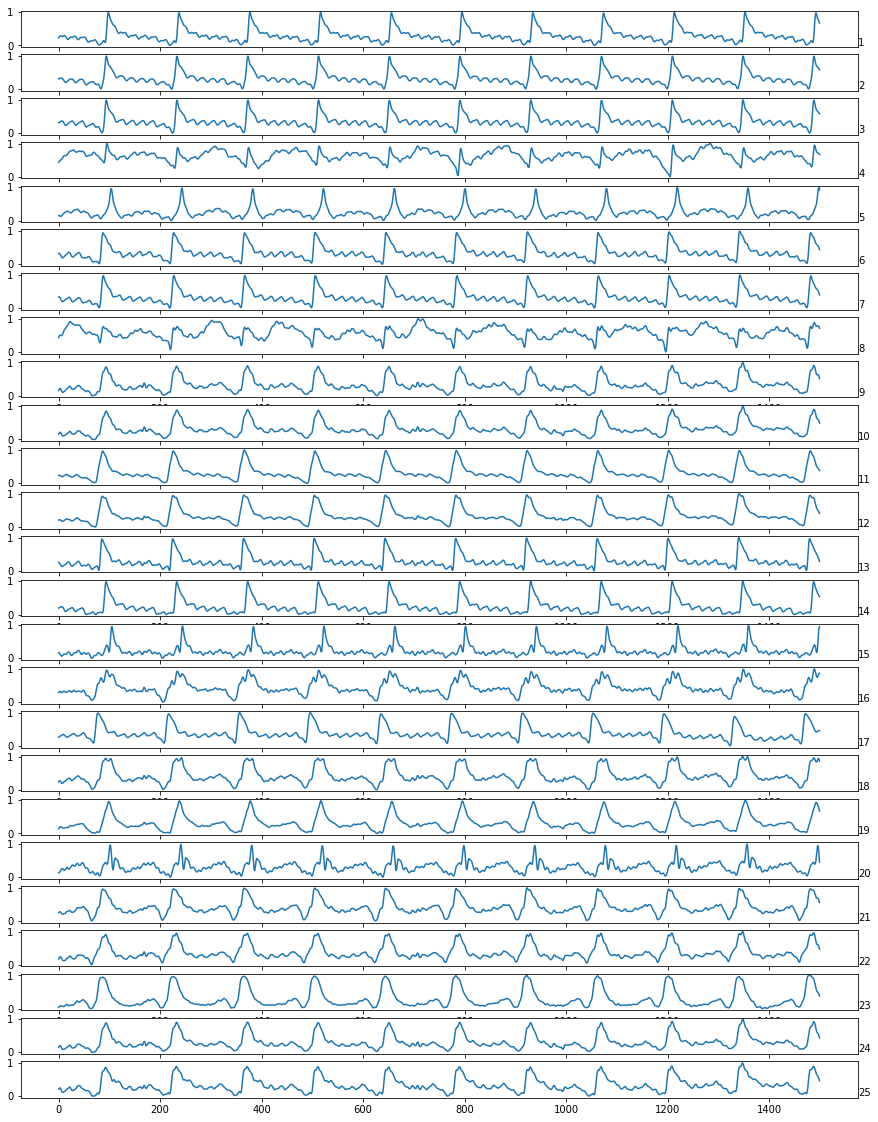

In [9]:
ecg_valid = ecg[250:1750, :]
ecg_valid = dataProc.channelNormalize(ecg_valid)
fig_ecg_valid = visualize.plot(ecg_valid)
fig_ecg_valid

# prediction

In [10]:
elec_256 = np.array([[61,201],[95,202],[128,202],[162,205],[196,206],
[62,168],[96,169],[128,170],[166,170],[194,174],
[64,135],[95,134],[130,136],[164,136],[196,140],
[62,101],[97,102],[130,102],[165,104],[203,107],
[65,68],[98,70],[130,69],[165,70],[196,72]], np.float32)

In [11]:
! mkdir /mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190717-1-6

mkdir: cannot create directory '/mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190717-1-6': File exists


In [12]:
np.save('/mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190717-1-6/12_256', elec_256)

In [13]:
elec_93 = np.zeros_like(elec_256)



In [14]:
elec_93[:, 0] = (elec_256[:, 0] - 49)*93/(213-49)
elec_93[:, 1] = (elec_256[:, 1] - 52)*93/(222-52)

In [15]:
np.save('/mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190717-1-6/12_93', elec_93)

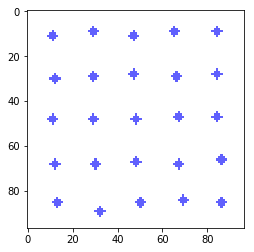

In [16]:
elec_img = analysis.drawElectrodes(elec_93, mapSize=(93, 93))
plt.imshow(elec_img)

In [17]:
ecg_maps_93 = pseudoEcg.interpolate(ecg_valid, elec_93, (93, 93))
ecg_maps_32 = dataProc.resizeSequence(ecg_maps_93, (32, 32), cv.INTER_LINEAR)
ecg_maps_32.shape

(1500, 32, 32, 1)

In [18]:
ecg_blocks = dataProc.sequenceToBlocks(ecg_maps_32, 320, 16)
ecg_blocks.shape

(5, 320, 32, 32, 1)

In [19]:
netg = resUnet3d.getModel(320, 32, 32, 1, 4, 32, 16, 'sigmoid')
netg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 32, 32,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 320, 32, 32,  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 32, 32,  64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 320, 32, 32,  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv3d_2 (

In [21]:
model_dir = '/mnt/Omer/Project/07.DeepElectrodeMapping/model/20190710_1/netg.h5'
netg.load_weights(model_dir)

InternalError: Dst tensor is not initialized.
	 [[Node: _arg_Placeholder_56_0_69/_547 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_495__arg_Placeholder_56_0_69", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

In [ ]:
pred_blocks = netg.predict(ecg_blocks)
pred_blocks.shape

In [ ]:
pred = dataProc.blocksToSequence(pred_blocks, 16)
pred.shape

In [ ]:
video = visualize.makeMovie(pred, 'plasma', 30)
video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190717-1-6/12_2_pred.mp4')

In [ ]:
np.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/prediction/exp/20190717_1_6/vm',pred)

# activation time

In [ ]:
ecg_actv = Ecg.filterEcg(ecg_raw, 1000, 30, 3, 2, 3, (50, 100), (3, 3))[250+16: 250+16+1440]
ecg_actv = dataProc.channelNormalize(ecg_actv)

In [ ]:
vmem_actv = activation.VmemFromActivation(ecg_actv, elec_93, (93, 93), vmem_min=0, vmem_max=1, prominence=0.4)

In [ ]:
fig_actv = visualize.plot(ecg_actv)
for k in range(len(fig_actv.axes)):
    for activation_time in vmem_actv.activation_time[k]:
        fig_actv.axes[k].axvline(activation_time, color='r')
fig_actv